In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from diffusers import AutoencoderKL
import pickle

[2024-11-19 12:23:26,874] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:


vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")


# torch_device = "cuda"
# vae.to(torch_device)

def encode_img(input_img):
    input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()






def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


/hpc/group/youlab/ks723/miniconda3/envs/test_pytorch_ipy/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:

foldername='/hpc/group/youlab/ks723/miniconda3/Lingchong/Latents'
latentname_input='latent_dim_75000_4channels_4x32x32_newintermediate102.pickle'
latentname_output='latent_dim_75000_4channels_4x32x32_newcomplex102.pickle'

filename_input=os.path.join(foldername,latentname_input)
filename_output=os.path.join(foldername,latentname_output)

pickle_in=open(filename_input,"rb")
# pickle_in=open("latent_dim_120000_4channels_4x32x32_Tp2.pickle","rb")

yprime_in=pickle.load(pickle_in)
# yprime=yprime.reshape(-1,img_width,img_length,4)

yprime_in=yprime_in[:30000,:,:,:]




pickle_in_output=open(filename_output,"rb")
yprime_in_output=pickle.load(pickle_in_output)
# yprime=yprime.reshape(-1,img_width,img_length,4)

yprime_in_output=yprime_in_output[:30000,:,:,:]


In [ ]:
yprime_in=torch.Tensor(yprime_in)
yprime_in_output=torch.Tensor(yprime_in_output)

yprime_scaled_in=yprime_in
yprime_scaled_in_output=yprime_in_output

# yprime_scaled=yprime
yprime_scaled_in=yprime_scaled_in.float()
yprime_scaled_in_output=yprime_scaled_in_output.float()


# Define train and test datasets
dataset = torch.utils.data.TensorDataset(yprime_scaled_in, yprime_scaled_in_output)
# Split dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size=64
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)


In [5]:
# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=18,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

from datetime import datetime
import time

currentSecond= datetime.now().second
currentMinute = datetime.now().minute
currentHour = datetime.now().hour

currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year



num_epochs = 500      
warmup_epochs=10
lr = 5e-4               #for fine tuning.
min_lr = 5e-6
gamma = 0.99

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model = ICToLatent()
#model.load_state_dict(torch.load('trained/pred_patterns_resnet.V1.pt'))
model.to(device)
print(f"Total Parameters in Neural Network: {count_parameters(model)}")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train_losses=[]
test_losses=[]

# Training parameters and early stopping initialization
best_loss = float('inf')
epochs_without_improvement = 0
patience = 20
delta = 0.03


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_params, batch_latents in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_params.to(device))
        loss = criterion(outputs, batch_latents.squeeze(1).to(device))
        
        loss.backward()
        
        # Warm-up schedule
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * (epoch + 1) / warmup_epochs
        
        optimizer.step()
        running_loss += loss.item()
    

    # Scheduler step after warmup
    if epoch >= warmup_epochs:
        scheduler.step()
    param_group['lr'] = max(param_group['lr'], min_lr)

   

    # Validation loop for testing set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_params, batch_latents in test_loader:
            outputs = model(batch_params.to(device))
            loss = criterion(outputs, batch_latents.squeeze(1).to(device))
            val_loss += loss.item()



    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    # Store losses in lists
    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    interval = 2 if epoch < 20 else 40
    if (epoch + 1)%interval == 0 or epoch+1 == num_epochs:
        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader):.6f} | Test Loss: {val_loss / len(test_loader):.6f}| lr: {param_group['lr']:0.7f}")
    
    
    # Early stopping logic with tolerance
    if avg_val_loss < best_loss - delta:
        # Significant improvement
        best_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Significant improvement observed. Best Validation Loss updated to {best_loss:.6f}.")
    elif avg_val_loss <= best_loss + delta:
        # Within tolerance
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Validation loss increased but within tolerance ({delta}). Continuing training.")
    else:
        # Exceeded tolerance
        epochs_without_improvement += 1
        print(f"Epoch {epoch + 1}: Validation loss increased beyond tolerance. Epochs without improvement: {epochs_without_improvement}/{patience}.")

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break


NAME =f"Pixel_32x32x3to32x32x4_dilRESNET_newpatterns_intermediatetocomplex_Model_v{currentMonth}{currentDay}_Cluster_GPU_tfData-{int(time.time())}"  # change this later to incorporate exact date 
torch.save(model.state_dict(), f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt')

cuda
Total Parameters in Neural Network: 2668100
Epoch 1: Significant improvement observed. Best Validation Loss updated to 0.623053.
Epoch [2/500] Train Loss: 0.566584 | Test Loss: 0.542455| lr: 0.0001000
Epoch 2: Significant improvement observed. Best Validation Loss updated to 0.542455.
Epoch 3: Significant improvement observed. Best Validation Loss updated to 0.512418.
Epoch [4/500] Train Loss: 0.490865 | Test Loss: 0.468275| lr: 0.0002000
Epoch 4: Significant improvement observed. Best Validation Loss updated to 0.468275.
Epoch 5: Validation loss increased but within tolerance (0.03). Continuing training.
Epoch [6/500] Train Loss: 0.429186 | Test Loss: 0.413956| lr: 0.0003000
Epoch 6: Significant improvement observed. Best Validation Loss updated to 0.413956.
Epoch 7: Validation loss increased but within tolerance (0.03). Continuing training.
Epoch [8/500] Train Loss: 0.388828 | Test Loss: 0.496784| lr: 0.0004000
Epoch 8: Validation loss increased beyond tolerance. Epochs without 

In [8]:
num_epochs = 1000       
warmup_epochs=10
lr = 5e-4               #for fine tuning.
min_lr = 5e-6
gamma = 0.99

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ICToLatent()
#model.load_state_dict(torch.load('trained/pred_patterns_resnet.V1.pt'))
model.to(device)
print(f"Total Parameters in Neural Network: {count_parameters(model)}")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

# Training parameters and early stopping initialization # to save best epoch
best_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 30
delta = 0.05 



train_losses=[]
test_losses=[]
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_params, batch_latents in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_params.to(device))
        loss = criterion(outputs, batch_latents.squeeze(1).to(device))
        
        loss.backward()
        
        # Warm-up schedule
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * (epoch + 1) / warmup_epochs
        
        optimizer.step()
        running_loss += loss.item()
    

    # Scheduler step after warmup
    if epoch >= warmup_epochs:
        scheduler.step()
    param_group['lr'] = max(param_group['lr'], min_lr)

   

    # Validation loop for testing set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_params, batch_latents in test_loader:
            outputs = model(batch_params.to(device))
            loss = criterion(outputs, batch_latents.squeeze(1).to(device))
            val_loss += loss.item()



    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    # Store losses in lists
    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    interval = 2 if epoch < 20 else 40
    if (epoch + 1)%interval == 0 or epoch+1 == num_epochs:
        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader):.6f} | Test Loss: {val_loss / len(test_loader):.6f}| lr: {param_group['lr']:0.7f}")
    
    
    # Early stopping logic with tolerance
    if avg_val_loss < best_loss - delta:
        # Significant improvement
        best_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Significant improvement observed. Best Validation Loss updated to {best_loss:.6f}.")
    elif avg_val_loss <= best_loss + delta:
        # Within tolerance
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Validation loss increased but within tolerance ({delta}). Continuing training.")
    else:
        # Exceeded tolerance
        epochs_without_improvement += 1
        print(f"Epoch {epoch + 1}: Validation loss increased beyond tolerance. Epochs without improvement: {epochs_without_improvement}/{patience}.")

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break


NAME =f"Pixel_32x32x3to32x32x4_RESNET_newpatterns_intermediatetocomplex_Model_v{currentMonth}{currentDay}_Cluster_GPU_tfData-{int(time.time())}"  # change this later to incorporate exact date 
torch.save(model.state_dict(), f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt')


cuda
Total Parameters in Neural Network: 1247876
Epoch 1: Significant improvement observed. Best Validation Loss updated to 0.533948.
Epoch [2/1000] Train Loss: 0.477453 | Test Loss: 0.438263| lr: 0.0001000
Epoch 2: Significant improvement observed. Best Validation Loss updated to 0.438263.
Epoch 3: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [4/1000] Train Loss: 0.368465 | Test Loss: 0.354170| lr: 0.0002000
Epoch 4: Significant improvement observed. Best Validation Loss updated to 0.354170.
Epoch 5: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [6/1000] Train Loss: 0.318760 | Test Loss: 0.311396| lr: 0.0003000
Epoch 6: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch 7: Significant improvement observed. Best Validation Loss updated to 0.299000.
Epoch [8/1000] Train Loss: 0.288561 | Test Loss: 0.287815| lr: 0.0004000
Epoch 8: Validation loss increased but within tolerance (0.05). 

In [6]:
# plot losses

import json
# Save losses and model details in a JSON file at the end of training
losses = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'best_loss': best_loss
    # 'saved_model_epoch': saved_model_epoch,
    # 'model_name': NAME
}

with open(f'/hpc/group/youlab/ks723/miniconda3/saved_models/logs/losses_{NAME}.json', 'w') as f:
    json.dump(losses, f, indent=4)


    

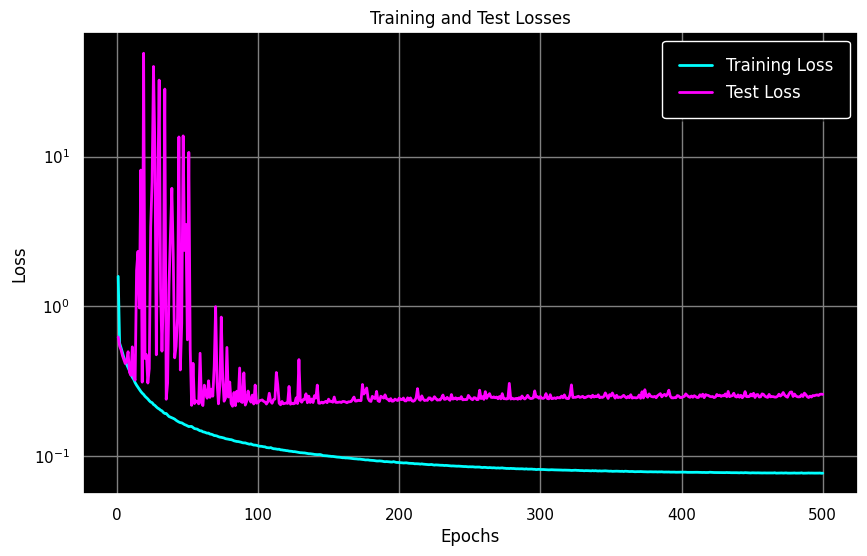

In [7]:
#

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot training and test losses with custom style
def plot_losses(train_losses, test_losses):
    sns.set(style='darkgrid', rc={"axes.facecolor": "black", "grid.color": "grey"})  # Setting the style
    plt.figure(figsize=(10, 6))
    
    epochs = np.arange(1, len(train_losses) + 1)  # Assuming train_losses and test_losses are of the same length
    
    plt.plot(epochs, train_losses, label='Training Loss', color='cyan', linewidth=2)  # Thicker line for Training Loss
    plt.plot(epochs, test_losses, label='Test Loss', color='magenta', linewidth=2)  # Thicker line for Test Loss
    
    plt.title('Training and Test Losses', color='black')
    plt.xlabel('Epochs', color='black')
    plt.ylabel('Loss', color='black')
    plt.yscale('log')  # Set y-axis to log scale
    
    plt.tick_params(axis='x', colors='black')  # Change tick color to white
    plt.tick_params(axis='y', colors='black')  # Change tick color to white
    
    plt.legend(facecolor='black', edgecolor='white', fontsize='medium', fancybox=True, framealpha=1, shadow=True, borderpad=1, labelcolor='white')
    plt.show()

# Make sure to call this function after the training loop
plot_losses(train_losses, test_losses)